In [1]:
from utils.configuration import get_config_from_json
from utils.training_utilities import set_GPU
from utils.plotting_traces import plot_traces
from seq2point.seq2point import SEQ2POINT
from refit_loader.data_loader import REFIT_Loader
from dataset_management.dataloader import Seq2PointDataLoader
import builtins
import os
import torch
from pprint import pprint

builtins.MODEL_CONFIG = get_config_from_json(description="Model Parameters", config_file="configs/model_config.json")
builtins.DATASET_CONFIG = get_config_from_json(description="Dataset Management", config_file="configs/dataset_config.json")
builtins.TRAINING_CONFIG = get_config_from_json(description="Training Configuration", config_file="configs/training_config.json")
builtins.PLOT_CONFIG = get_config_from_json(description="Plot Settings", config_file="configs/plot_config.json")

In [2]:

def main():
    
    ###### random seed selection in progress

    random_seed = 10

    network = SEQ2POINT().to(set_GPU())
    
    dataloaders = Seq2PointDataLoader(target_appliance='kettle', target_houses= {'TRAIN' : [2], 'VALIDATE': [2], 'TEST':[2]}, proportion= {'train_percent':0.7, 'validate_percent':0.2}, subset_days=1)
    
    train_loss, validation_loss = network.run(dataloaders.train_dataloader, dataloaders.validation_dataloader)

    plot_traces(traces = [train_loss, validation_loss], labels=['training', 'validation'], axis_labels=['Epochs', 'Loss'], title='Training Loss vs Validation Loss per Epoch')



Initializing SEQ2POINT model archiecture

Followings are the Model Parameters of your network architecture..
{'CONV_KERNEL': [10, 8, 6, 5, 5],
 'CONV_LAYERS': 5,
 'CONV_PADDING': 0,
 'CONV_STRIDE': 1,
 'DESCRIPTION': 'Model Parameters',
 'INPUT_CHANNELS': [1, 30, 30, 40, 50],
 'LEFT_PAD': [4, 3, 2, 2, 2],
 'LINEAR_INPUT': [29950, 1024],
 'LINEAR_LAYERS': 2,
 'LINEAR_OUTPUT': [1024, 1],
 'OUTPUT_CHANNELS': [30, 30, 40, 50, 50],
 'POOL_KERNEL': [],
 'POOL_STRIDE': [],
 'RIGHT_PAD': [5, 4, 3, 2, 2],
 'SEQUENCE_LENGTH': 599}

SEQ2POINT model archiecture has been initialized

Error occured in __same_house_approach method due to  'Seq2PointDataLoader' object has no attribute 'target_houses'
Followings are the refit_loader configuration of your experiment..
{'DATA_FOLDER': 'data/refit/', 'DATA_TYPE': '.csv', 'README_FILE': 'refit_loader/REFIT_Readme.txt', 'REFIT_HOUSES': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]}

Loading specified buildings: [1, 2, 3, 4, 5, 6, 

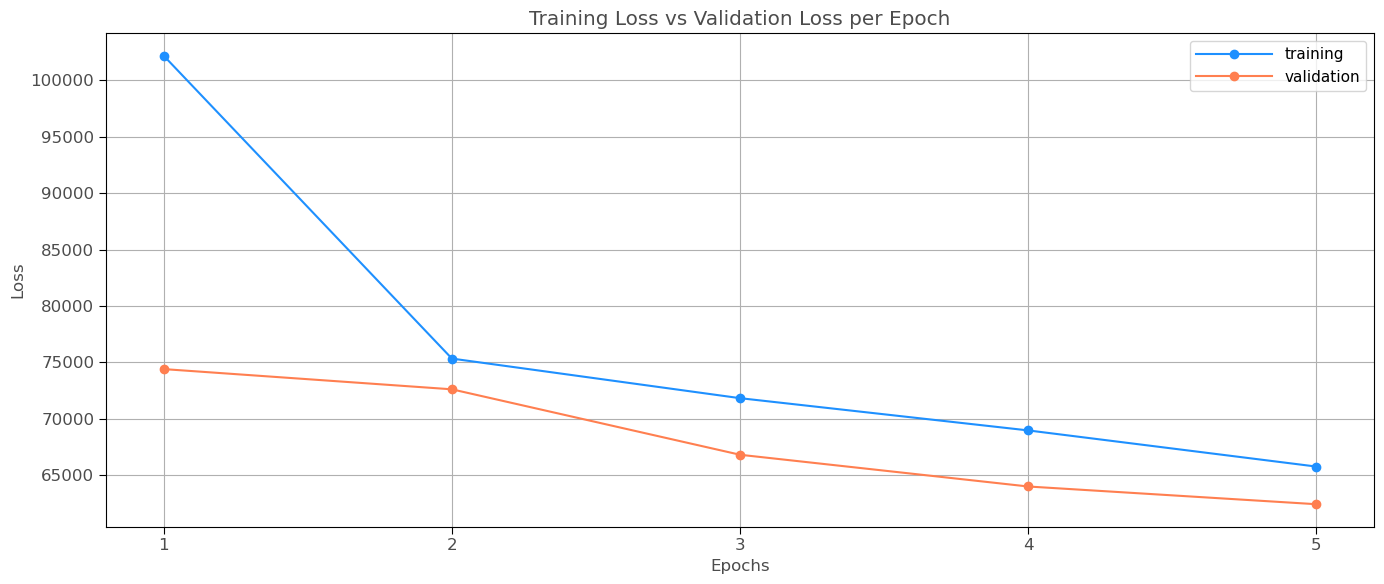

In [3]:
main()